導入資料 初步檢查

In [1]:
import warnings
warnings.filterwarnings("ignore")  # 屏蔽 warning

%matplotlib inline

import pandas as pd

df = pd.read_csv('./dataset/train.csv')
print(df.head(5))

   Id  Popularity                                       Page content
0   0          -1  <html><head><div class="article-info"> <span c...
1   1           1  <html><head><div class="article-info"><span cl...
2   2           1  <html><head><div class="article-info"><span cl...
3   3          -1  <html><head><div class="article-info"><span cl...
4   4          -1  <html><head><div class="article-info"><span cl...


預處理資料

In [ ]:
import re
from bs4 import BeautifulSoup
from nltk.stem.porter import PorterStemmer
import nltk
from nltk.corpus import stopwords

def preprocessor(text):
    # 去除 HTML 標籤
    text = BeautifulSoup(text, 'html.parser').get_text()

    # 找出所有的表情符號
    r = '(?::|;|=|X)(?:-)?(?:\)|\(|D|P)'
    emoticons = re.findall(r, text)
    text = re.sub(r, '', text)

    # 移除非字母數字的符號，轉成小寫
    # 把 - 去掉，並把表情符號加回來
    text = re.sub('[\W]+', ' ', text.lower()) + ' ' + ' '.join(emoticons).replace('-','')
    return text

# 分詞
def tokenizer(text):
    return re.split('\s+', text.strip())

# 詞幹提取
def tokenizer_stem(text):
    porter = PorterStemmer()
    return [porter.stem(word) for word in re.split('\s+', text.strip())]

# 去除停用詞 
nltk.download('stopwords')
stop = stopwords.words('english')

def tokenizer_stem_nostop(text):
    porter = PorterStemmer()
    return [porter.stem(w) for w in re.split('\s+', text.strip()) \
            if w not in stop and re.match('[a-zA-Z]+', w)]

檢查預處理

In [101]:
# 詳細檢查數據和標籡的關係
print("=== 數據質量檢查 ===")

# 檢查標籡分布
print("標籡分布:")
print(f"正樣本比例: {np.mean(y_train == 1):.3f}")

# 隨機抽樣檢查
np.random.seed(42)
sample_indices = np.random.choice(len(X_train), 5, replace=False)

for i, idx in enumerate(sample_indices):
    text_sample = X_train.iloc[idx] if hasattr(X_train, 'iloc') else X_train[idx]
    label = y_train[idx]
    print(f"\n樣本 {i+1} (標籡: {label}):")
    print(f"文本開頭: {str(text_sample)[:200]}...")
    print(f"文本長度: {len(str(text_sample))} 字符")

    # 詳細測試預處理流程
test_texts = [
    "excellent amazing wonderful fantastic superb",  # 正面詞彙
    "terrible awful horrible disgusting bad",        # 負面詞彙  
    "the and or but if then because",                # 停用詞
    "123 !@# $%^ &*() __++",                         # 特殊字符
]

print("=== 預處理測試 ===")
for i, text in enumerate(test_texts):
    processed = preprocessor(text)
    tokens = tokenizer_stem_nostop(processed)
    print(f"{i+1}. 輸入: '{text}'")
    print(f"   輸出: '{processed}'")
    print(f"   分詞: {tokens}")
    print(f"   有效詞數: {len(tokens)}")
    print()

=== 數據質量檢查 ===
標籡分布:
正樣本比例: 0.455


KeyError: 521

核心外學習  特徵哈希

In [ ]:
import numpy as np
from sklearn.feature_extraction.text import HashingVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import roc_auc_score
import scipy as sp


# 用流式讀取資料
def get_stream(path, size):
    for chunk in pd.read_csv(path, chunksize=size):
        # 将Popularity从[-1, 1]映射到[0, 1]
        chunk['Popularity'] = chunk['Popularity'].apply(lambda x: 1 if x == 1 else 0)
        yield chunk

# 修改类别数组
classes = np.array([0, 1])  # 改为0和1

# 创建独立的训练和验证流
def get_data_streams(path, train_size=20000, val_size=5000, batch_size=1000):
    """創建獨立的訓練和驗證數據流"""
    # 先讀取所有數據
    df = pd.read_csv(path)
    
    # 映射標籤：將-1改為0，1保持為1
    df['Popularity'] = df['Popularity'].apply(lambda x: 1 if x == 1 else 0)
    
    # 分割訓練驗證
    train_df = df.iloc[:train_size]
    val_df = df.iloc[train_size:train_size+val_size]
    
    # 創建生成器 - 添加結束條件
    def train_generator():
        for i in range(0, len(train_df), batch_size):
            batch = train_df.iloc[i:i+batch_size]
            if len(batch) > 0:  # 確保batch不為空
                yield batch
    
    def val_generator():
        for i in range(0, len(val_df), batch_size):
            batch = val_df.iloc[i:i+batch_size]
            if len(batch) > 0:  # 確保batch不為空
                yield batch
    
    return train_generator(), val_generator(), len(train_df), len(val_df)

# 使用改進的數據流
train_stream, val_stream, train_size, val_size = get_data_streams('./dataset/train.csv')

# 建立 HashingVectorizer
hashvec = HashingVectorizer(n_features=2**16,
                            preprocessor=preprocessor, tokenizer=tokenizer_stem_nostop)

# 建立 SGDClassifier
# loss='log' gives logistic regression
clf = SGDClassifier(
    loss='log_loss',
    penalty='elasticnet',   # 'l2' 也行，但 elasticnet 往往更抗过拟合
    alpha=0.01,             # 比默认 1e-4 强，必要时再加到 1e-2
    l1_ratio=0.3, 
    learning_rate='optimal',   # 讓算法自動調整學習率
    eta0=0.001,                # 初始學習率
    max_iter=1,
    tol=None,
    random_state=42
)

train_auc, val_auc = [], []
batch_size = 1000
iters = int((train_size + batch_size - 1) / batch_size)

# 預先獲取驗證批次
val_batches = list(val_stream)  # 將生成器轉換為列表
val_batch_index = 0

for i in range(iters):
    try:
        # 訓練
        train_batch = next(train_stream)
        X_train, y_train = train_batch['Page content'], train_batch['Popularity']
        X_train_vec = hashvec.transform(X_train)
        clf.partial_fit(X_train_vec, y_train, classes=classes)
        
        # 計算訓練AUC
        train_pred = clf.predict_proba(X_train_vec)[:, 1]
        train_auc.append(roc_auc_score(y_train, train_pred))
        
        # 驗證（每幾個batch驗證一次）
        if i % 4 == 0 and val_batch_index < len(val_batches):
            val_batch = val_batches[val_batch_index]
            X_val, y_val = val_batch['Page content'], val_batch['Popularity']
            X_val_vec = hashvec.transform(X_val)
            val_pred = clf.predict_proba(X_val_vec)[:, 1]
            val_score = roc_auc_score(y_val, val_pred)
            val_auc.append(val_score)
            val_batch_index += 1
            
            print(f'[{i+1}/{iters}] Train AUC: {train_auc[-1]:.4f}, Val AUC: {val_score:.4f}')
        else:
            print(f'[{i+1}/{iters}] Train AUC: {train_auc[-1]:.4f}')
            
    except StopIteration:
        print("數據流已結束")
        break

[1/20] Train AUC: 0.5169, Val AUC: 0.4872
[2/20] Train AUC: 0.5034
[3/20] Train AUC: 0.5258
[4/20] Train AUC: 0.5271
[5/20] Train AUC: 0.5227, Val AUC: 0.5029
[6/20] Train AUC: 0.5198
[7/20] Train AUC: 0.5306
[8/20] Train AUC: 0.5472
[9/20] Train AUC: 0.5459, Val AUC: 0.5256
[10/20] Train AUC: 0.5380
[11/20] Train AUC: 0.5169
[12/20] Train AUC: 0.5281
[13/20] Train AUC: 0.4932, Val AUC: 0.4810
[14/20] Train AUC: 0.5214
[15/20] Train AUC: 0.4913
[16/20] Train AUC: 0.5296
[17/20] Train AUC: 0.5261, Val AUC: 0.4752
[18/20] Train AUC: 0.5277
[19/20] Train AUC: 0.5476
[20/20] Train AUC: 0.5213


In [102]:
# 檢查特徵矩陣是否正常
print("特徵矩形狀:", X_train_vec.shape)
print("非零元素比例:", X_train_vec.nnz / (X_train_vec.shape[0] * X_train_vec.shape[1]))
print("特徵均值:", X_train_vec.mean())

# 檢查是否有NaN或無限值
if sp.sparse.issparse(X_train_vec):
    if np.any(~np.isfinite(X_train_vec.data)):
        print("警告: 特徵中包含非有限值!")

# 分析特徵提取結果
print("=== 特徵提取分析 ===")

# 測試特徵提取的一致性
sample_texts = [
    "good great excellent",
    "bad terrible awful", 
    "neutral text content"
]

for text in sample_texts:
    vec = hashvec.transform([text])
    print(f"文本: '{text}'")
    print(f"特徵數: {vec.nnz}")
    if vec.nnz > 0:
        print(f"特徵值: {vec.data}")
    print()



特徵矩形狀: (1000, 65536)
非零元素比例: 0.00299847412109375
特徵均值: 2.802582289076962e-06
=== 特徵提取分析 ===
文本: 'good great excellent'
特徵數: 3
特徵值: [0.57735027 0.57735027 0.57735027]

文本: 'bad terrible awful'
特徵數: 3
特徵值: [ 0.57735027 -0.57735027  0.57735027]

文本: 'neutral text content'
特徵數: 3
特徵值: [-0.57735027 -0.57735027  0.57735027]



繪製學習曲線

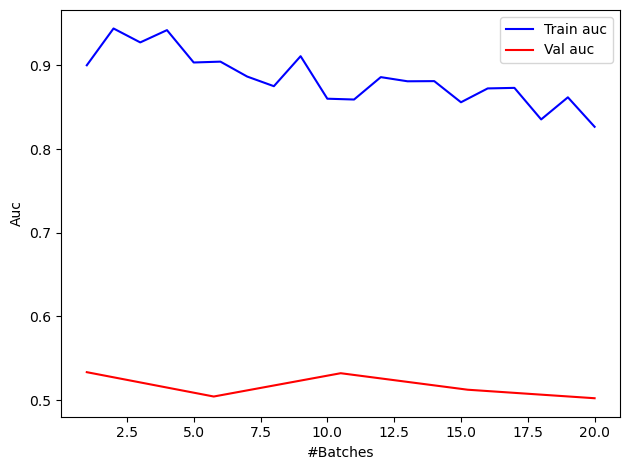

In [87]:
import os
if not os.path.exists('output'):
    os.mkdir('output')

import matplotlib.pyplot as plt

plt.plot(range(1, len(train_auc)+1), train_auc, color='blue', label='Train auc')
plt.plot(
    np.linspace(1, len(train_auc), len(val_auc)), 
    val_auc, 
    color='red', 
    label='Val auc'
)
plt.legend(loc="best")
plt.xlabel('#Batches')
plt.ylabel('Auc')
plt.tight_layout()
plt.savefig('./output/fig-out-of-core.png', dpi=300)
plt.show()

定期保存

In [ ]:
# import optimized pickle written in C for serializing and
# de-serializing a Python object
import _pickle as pkl

# dump to disk
pkl.dump(hashvec, open('output/hashvec.pkl', 'wb'))
pkl.dump(clf, open('output/clf-sgd.pkl', 'wb'))

# load from disk
hashvec = pkl.load(open('output/hashvec.pkl', 'rb'))
clf = pkl.load(open('output/clf-sgd.pkl', 'rb'))

df_test = pd.read_csv('./dataset/test.csv')
import scipy as sp
test_pred = sp.special.expit(clf.decision_function(hashvec.transform(df_test['Page content'])))

submission = pd.DataFrame({
    'Id': df_test['Id'],
    'Popularity': test_pred
})
submission.to_csv('output/submission.csv', index=False)
print('Test predictions saved to output/submission.csv')

Test predictions saved to output/submission.csv


修正成一位精度

In [ ]:
import pandas as pd
from decimal import Decimal, ROUND_HALF_UP

df = pd.read_csv('output/submission.csv', usecols=['Id', 'Popularity'])

# Popularity 严格四舍五入到一位小数（ROUND_HALF_UP）
df['Popularity'] = df['Popularity'].map(
    lambda x: float(Decimal(str(x)).quantize(Decimal('0.0'), rounding=ROUND_HALF_UP))
).astype('float32')

# Id 保持整数（可选）
df['Id'] = df['Id'].astype('int64')

# 写出新文件
df.to_csv('output/submission_13.csv', index=False, float_format='%.1f')
print('saved -> output/submission_13.csv')


saved -> output/submission_12.csv
